In [ ]:
import numpy as np
import pandas as pd
import import_ipynb
import lstm_def
from keras.layers import Dense, LSTM, BatchNormalization, MaxPool1D
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers.convolutional import Conv1D

In [ ]:
from sklearn.preprocessing import RobustScaler
import import_ipynb
import isee_def

In [ ]:
####################################
# train 데이터 load
####################################

merged_df = pd.read_csv('./isee_data/isee_machine_middel_NG_enc.csv')
merged_df['NG_Label']= merged_df['NG'] + merged_df['NG5']

up_list = merged_df['ProductNum'].unique()

# 제품 'PL04496-03040' 대상
df = merged_df[merged_df['ProductNum']==up_list[0]]

In [56]:
feature = isee_def.get_analy_enc_df(df)
y_label = df[['NG5','CycleNum','NG_Label']]
scaled_X = pd.DataFrame(RobustScaler().fit_transform(feature), columns=feature.columns, index=df.index)
scaled_df = pd.concat([scaled_X, y_label], axis=1)

- X: train data set 생성
- label: train data set에 해당하는 라벨(sequence의 마지막 값을 라벨로 지정)

In [113]:
w=20
s=4
X = np.zeros(len(feature.columns), w))
label = []
for c in scaled_df['CycleNum'].unique():
    df = scaled_df[scaled_df['CycleNum']==c]
    df = df.reset_index(drop=True)
    for i in range(int((len(df)-w)/s+1)):
        X = np.concatenate((X, df.loc[s*i:s*i+w-1][feature.columns].T.values)) 
        label.append(df.loc[s*i+w-1]['NG_Label'])

In [172]:
yy = [0 if x == 0 else 1 for x in label]

In [177]:
len(yy) , sum(yy)

(22186, 4519)

In [140]:
X = X.reshape(-1,18,20)
X = X[1:]

In [155]:
y = pd.get_dummies(label).values

In [176]:
#############################
# create the model
#############################
model = Sequential()
#model.add(Conv1D(filters= 64, kernel_size=3, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(LSTM(100, activation = 'tanh', return_sequences= True, input_shape=(18,20)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, yy, epochs=3, batch_size=32)

Epoch 1/3
22186/22186 [==============================] - 26s 1ms/step - loss: 0.4729 - acc: 0.8025
Epoch 2/3
22186/22186 [==============================] - 23s 1ms/step - loss: 0.4404 - acc: 0.8120
Epoch 3/3
22186/22186 [==============================] - 27s 1ms/step - loss: 0.4228 - acc: 0.8244


In [162]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 18, 100)           48400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 153       
Total params: 78,753
Trainable params: 78,753
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
####################################
# test 데이터 load
####################################
#ori_test = pd.read_csv('./data/test_FD0001_true5.csv',encoding= 'cp949')

In [164]:
####################################
# model 평가
####################################
scores = model.evaluate(X, y)

22186/22186 [==============================] - 7s 329us/step


In [165]:
scores

[0.5298509761606466, 0.8086631208870458]

In [178]:
y_pre = model.predict_classes(X)
np.unique(y_pre)

array([0, 1])

In [30]:
"""
# 실제값에 대한 예측값의 오류 정도를 파악하기 위해 엑셀로 저장
df_y_real = pd.DataFrame(y_test2)
df_y_pre = pd.DataFrame(y_pre)
df_y = pd.concat([df_y_real, df_y_pre], axis=1)
df_y.columns = ['real', 'predict']

df_y.to_excel("df_y.xlsx")
"""

'\n# 실제값에 대한 예측값의 오류 정도를 파악하기 위해 엑셀로 저장\ndf_y_real = pd.DataFrame(y_test2)\ndf_y_pre = pd.DataFrame(y_pre)\ndf_y = pd.concat([df_y_real, df_y_pre], axis=1)\ndf_y.columns = [\'real\', \'predict\']\n\ndf_y.to_excel("df_y.xlsx")\n'

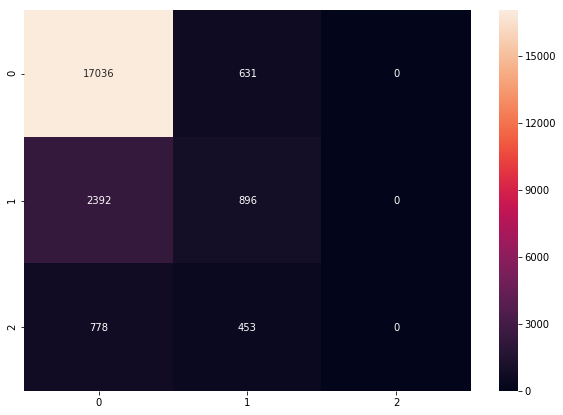

In [181]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

df_cm = pd.DataFrame(confusion_matrix(label, y_pre))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

In [32]:
zero_list = np.zeros((max_review_length, 17))
zero_list = zero_list.reshape(1,zero_list.shape[0], zero_list.shape[1])
zero_list.shape
zero_pre = model.predict(zero_list)
zero_pre

array([[9.94183e-05]], dtype=float32)